In [1]:
import pandas as pd
import numpy as np
import random
from faker import Faker

In [2]:
#set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

#initialize faker with a seed
fake = Faker()
Faker.seed(SEED)


##

In [3]:
#loading the dataset

path = "campaign_performance.xlsx"

df_campaigns = pd.read_excel(path,sheet_name="campaigns")
df_metrics = pd.read_excel(path, sheet_name="campaign_metrics")
df_transactions = pd.read_excel(path, sheet_name="transactions")

In [ ]:
preferences = {
    "Generation Z": {
        "Age Range": (18, 27),
        "Shopping Preference": {
            "Male": {
                "Groceries": [0.3, 0.1],  # Weight: 30%, Spending deviation: 10%
                "Health and Beauty": [0.15, 0.05],
                "Electronics": [0.55, 0.3],
            },
            "Female": {
                "Groceries": [0.3, 0.1],
                "Health and Beauty": [0.45, 0.15],
                "Electronics": [0.25, 0.2],
            },
        },
    },
    "Millennials": {
        "Age Range": (28, 40),
        "Shopping Preference": {
            "Male": {
                "Groceries": [0.35, 0.1],
                "Health and Beauty": [0.15, 0.1],
                "Electronics": [0.5, 0.25],
            },
            "Female": {
                "Groceries": [0.4, 0.15],
                "Health and Beauty": [0.4, 0.2],
                "Electronics": [0.2, 0.2],
            },
        },
    },
    "Boomers": {
        "Age Range": (41, 65),
        "Shopping Preference": {
            "Male": {
                "Groceries": [0.5, 0.2],
                "Health and Beauty": [0.2, 0.1],
                "Electronics": [0.3, 0.15],
            },
            "Female": {
                "Groceries": [0.6, 0.25],
                "Health and Beauty": [0.3, 0.15],
                "Electronics": [0.1, 0.1],
            },
        },
    },
}





In [10]:
class CampaignDataset():

    def __init__(self, df_campaigns:pd.DataFrame, df_metrics:pd.DataFrame, df_transactions:pd.DataFrame):

        self.campaigns = df_campaigns
        self.metrics = df_metrics
        self.transactions = df_transactions

    def _get_campaign_ids(self):
        return self.campaigns["campaign_id"].unique()
    
    def _get_campaign_interval(self, campaign_id):
        selected_campaign = self.campaigns[self.campaigns["campaign_id"] == campaign_id]
        start_date, end_date = selected_campaign["start_date"].iloc[0], selected_campaign["end_date"].iloc[0]
        return start_date, (end_date - start_date).days

    def generate_synthetic_transactions(self, campaign_id: int, num_new_rows: int, preferences: dict):
        """
        Generate synthetic transactions for a campaign based on generational shopping preferences.

        Args:
            campaign_id (int): The campaign ID to mimic.
            num_new_rows (int): Number of new synthetic transactions to generate.
            preferences (dict): A dictionary containing shopping preferences and deviations for each generation.

        Returns:
            pd.DataFrame: DataFrame of new synthetic transactions.
        """
        transaction_df = self.transactions[self.transactions["campaign_id"] == campaign_id]
        start_date, campaign_length = self._get_campaign_interval(campaign_id)

        new_rows = []

        for _ in range(num_new_rows):
            # Randomly select an existing row (from transaction_df or new_rows if applicable)
            campaign = transaction_df.sample(1).iloc[0]

            # Determine if the transaction will reuse customer details (duplicate scenario)
            duplicate = random.randint(0, 10) > 9

            if duplicate:
                use_new_rows = random.choice([True, False])
                if use_new_rows and len(new_rows) != 0:
                    # Pick a random entry from existing new rows for duplicates
                    campaign = random.choice(new_rows)

                # Reuse existing customer details
                customer_id = campaign["customer_id"]
                gender = campaign["gender"]
                age = campaign["age"]
            else:
                # Generate a new customer
                customer_id = fake.uuid4()
                gender = random.choice(["Male", "Female"])
                age = random.randint(18, 65)

            # Determine generation and apply preferences
            generation = None
            for gen_name, gen_info in preferences.items():
                if gen_info["Age Range"][0] <= age <= gen_info["Age Range"][1]:
                    generation = gen_name
                    break

            if generation is None:
                raise ValueError(f"Age {age} does not fit into any defined generation in preferences.")

            # Get shopping preferences for this generation and gender
            gen_preferences = preferences[generation]["Shopping Preference"][gender]

            # Select a product category based on weights
            product_category = random.choices(
                population=list(gen_preferences.keys()),
                weights=[prefs[0] for prefs in gen_preferences.values()],
                k=1
            )[0]

            # Adjust transaction amount using spending deviation
            base_amount = campaign["amount"]
            spending_deviation = gen_preferences[product_category][1]
            adjusted_amount = round(base_amount * random.uniform(1 - spending_deviation, 1 + spending_deviation))

            # Generate new transaction details
            new_transaction = {
                "campaign_id": campaign_id,
                "transaction_id": int(self.transactions["transaction_id"].max() + len(new_rows) + 1),
                "amount": adjusted_amount,
                "transaction_date": start_date + pd.Timedelta(days=random.randint(0, campaign_length)),
                "customer_id": customer_id,
                "gender": gender,
                "age": age,
                "product_category": product_category,
            }
            new_rows.append(new_transaction)

        return pd.concat([transaction_df,pd.DataFrame(new_rows)])



In [11]:
campaign_dataset = CampaignDataset(df_campaigns, df_metrics, df_transactions)

extrapolated_transaction = campaign_dataset.generate_synthetic_transactions(301,1000,preferences)

<Axes: >

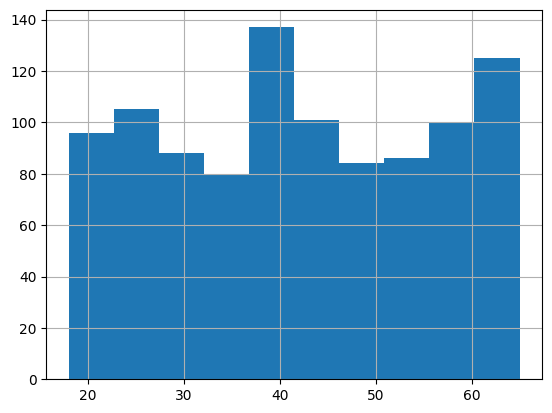

In [12]:
extrapolated_transaction["age"].hist()

In [ ]:
def generate_synthetic_transactions(df:pd.DataFrame, num_new_rows:int, campaign_id=int):

    campaign_df = df[df["campaign_id"] == campaign_id]

    new_rows = []
    for _ in range(num_new_rows):
        # Randomly select an existing campaign to mimic
        campaign = campaign_df.sample(1).iloc[0]
        
        # Generate new transaction details
        new_transaction = {
            "campaign_id": campaign_id,
            "transaction_id": int(campaign_df["transaction_id"].max() + len(new_rows) + 1),
            "amount": round(campaign["amount"] * random.uniform(0.8, 1.2)),  # Add variability to the amount
            "transaction_date": pd.to_datetime(campaign["transaction_date"]) + pd.Timedelta(days=random.randint(1, 30)),
            "customer_id": fake.uuid4(),
            "gender": random.choice(["Male", "Female"]),
            "age": random.randint(18, 65),
            "product_category": random.choice(df["product_category"].unique()),
        }
        new_rows.append(new_transaction)
    
    return pd.DataFrame(new_rows)

In [ ]:
generate_synthetic_transactions(df_transactions, 20, 301)

,campaign_id,transaction_id,amount,transaction_date,customer_id,gender,age,product_category
0,301,3,171,2024-01-29,a9488d99-0bbb-4599-91ce-5dd2b45ed1f0,Female,65,Health & Beauty
1,301,4,174,2024-01-19,fc377a4c-4a15-444d-85e7-ce8a3a578a8e,Female,32,Groceries
2,301,5,201,2024-01-08,ddd1dfb2-3b98-4ef8-9af6-1a26146d3f31,Male,25,Groceries
3,301,6,210,2024-01-31,7412b293-4729-4739-a14f-f3d719db3ad0,Female,56,Groceries
4,301,7,191,2024-01-25,29a3b2e9-5d65-4441-9588-42dea2bc372f,Female,51,Health & Beauty
5,301,8,238,2024-02-02,ab9099a4-35a2-40ae-9af3-05535ec42e08,Male,61,Groceries
6,301,9,215,2024-01-23,aefcfad8-efc8-4849-b3aa-7efe4458a885,Female,59,Health & Beauty
7,301,10,169,2024-01-19,a28defe3-9bf0-4273-9247-6f57a5e5a5ab,Male,47,Groceries
8,301,11,236,2024-02-03,3eabedcb-baa8-4dd4-88bd-64072bcfbe01,Female,50,Groceries
9,301,12,201,2024-01-09,451b4cf3-6123-4df7-b656-af7229d4beef,Female,58,Groceries
